This notebook visualises rasters and calculates zonal statistics by township, and inserts results into database table.

In [2]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import text
import rasterstats
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Create a SQLAlchemy engine
conn_string = "postgresql://lizavabistsevits:@localhost:5432/taiwan" # database connection string
engine = create_engine(conn_string)

# Insert township geom into geodataframe
townships = gpd.read_postgis(
    "SELECT code, name, geom FROM townships", 
    engine, 
    geom_col="geom"
)

townships.head(5)

,code,name,geom
0,68000040,Yangmei District,"MULTIPOLYGON (((265128.924 2760180.407, 265142..."
1,64000160,Dashe District,"MULTIPOLYGON (((189599.603 2517612.872, 189596..."
2,64000140,Daliao District,"MULTIPOLYGON (((191951.502 2503292.163, 191940..."
3,64000150,Dashu District,"MULTIPOLYGON (((193966.334 2519114.849, 193954..."
4,64000330,Jiaxian District,"MULTIPOLYGON (((214323.657 2567413.723, 214356..."


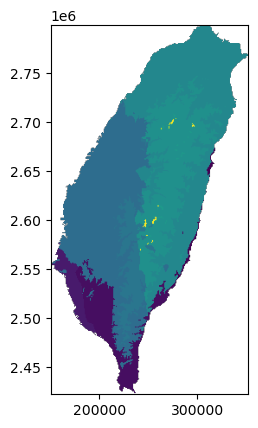

<Axes: >

In [4]:
climate_zones = rasterio.open("../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif")
show(climate_zones)

In [5]:
# Calculate zonal statistics for climate zones
zs_cz = zonal_stats(townships, "../data/koppen_geiger_tif/1991_2020/kg_tw_clipped_3826.tif", stats=['majority']) # zonal_stats creates a list of dictionary objects
#print(zs_cz)

In [6]:
# Create dataframe with zonal statistics
stats_cz = pd.DataFrame(zs_cz)
stats_cz.rename(columns={'majority':'major_climate_zone'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_cz], axis=1)

In [6]:
# Insert elevation into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET main_climate = :climate_zone 
            WHERE code = :township_code
        """)
        connection.execute(query, {"climate_zone": row['major_climate_zone'], "township_code": row['code']})

(2400000.0, 2850000.0)

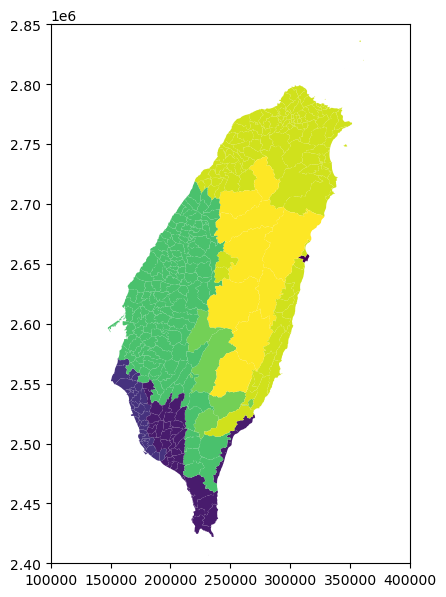

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
townships.plot(
    column='major_climate_zone',
    ax=ax)

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

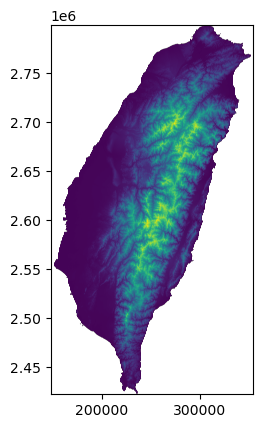

<Axes: >

In [8]:
dem = rasterio.open("../data/elevation/TWN_DEM_3826_Clipped.tif")
show(dem)

In [22]:
# Calculate zonal statistics for elevation (DEM)
zs_dem = zonal_stats(townships, "../data/elevation/TWN_DEM_3826_Clipped.tif", stats=['mean', 'median', 'max'])
#print(zs_dem)

In [23]:
# Create dataframe with zonal statistics
stats_dem = pd.DataFrame(zs_dem)
stats_dem.rename(columns={'mean':'mean_elevation', 'median':'median_elevation', 'max':'max_elevation'}, inplace=True)

# Merge with townships
townships = pd.concat([townships, stats_dem], axis=1)
townships.head(5)

,code,name,geom,major_climate_zone,max_elevation,mean_elevation,median_elevation
0,68000040,Yangmei District,"MULTIPOLYGON (((265128.924 2760180.407, 265142...",14.0,387.690002,169.584657,158.550003
1,64000160,Dashe District,"MULTIPOLYGON (((189599.603 2517612.872, 189596...",2.0,210.720001,46.334724,34.169998
2,64000140,Daliao District,"MULTIPOLYGON (((191951.502 2503292.163, 191940...",2.0,91.830002,18.708464,15.429999
3,64000150,Dashu District,"MULTIPOLYGON (((193966.334 2519114.849, 193954...",2.0,247.279999,71.961801,60.470001
4,64000330,Jiaxian District,"MULTIPOLYGON (((214323.657 2567413.723, 214356...",11.0,1668.570068,601.719399,520.510010


In [11]:
# Insert elevation into townships table
with engine.begin() as connection:
    for index, row in townships.iterrows():
        query = text("""
            UPDATE townships
            SET elevation = :elevation 
            WHERE code = :township_code
        """)
        connection.execute(query, {"elevation": row['mean_elevation'], "township_code": row['code']})

(2400000.0, 2850000.0)

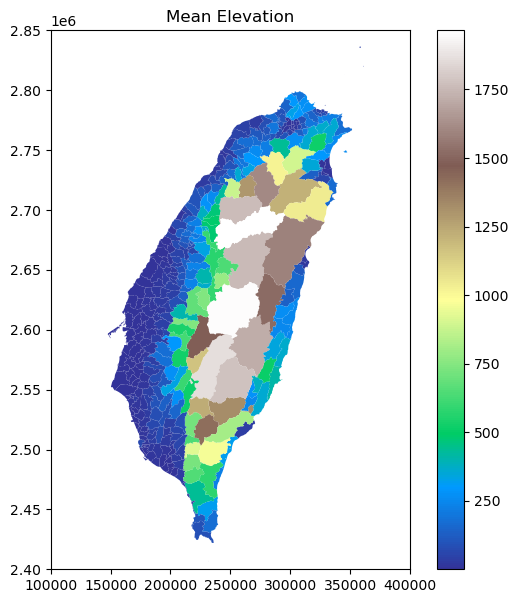

In [34]:
f, ax = plt.subplots(figsize=(7, 7))
townships.plot(
    column='mean_elevation', 
    cmap='terrain',
    legend=True,
    ax=ax)

ax.set_title('Mean Elevation')

# Specify coordinates for the plot
ax.set_xlim(100000, 400000)
ax.set_ylim(2400000, 2850000)

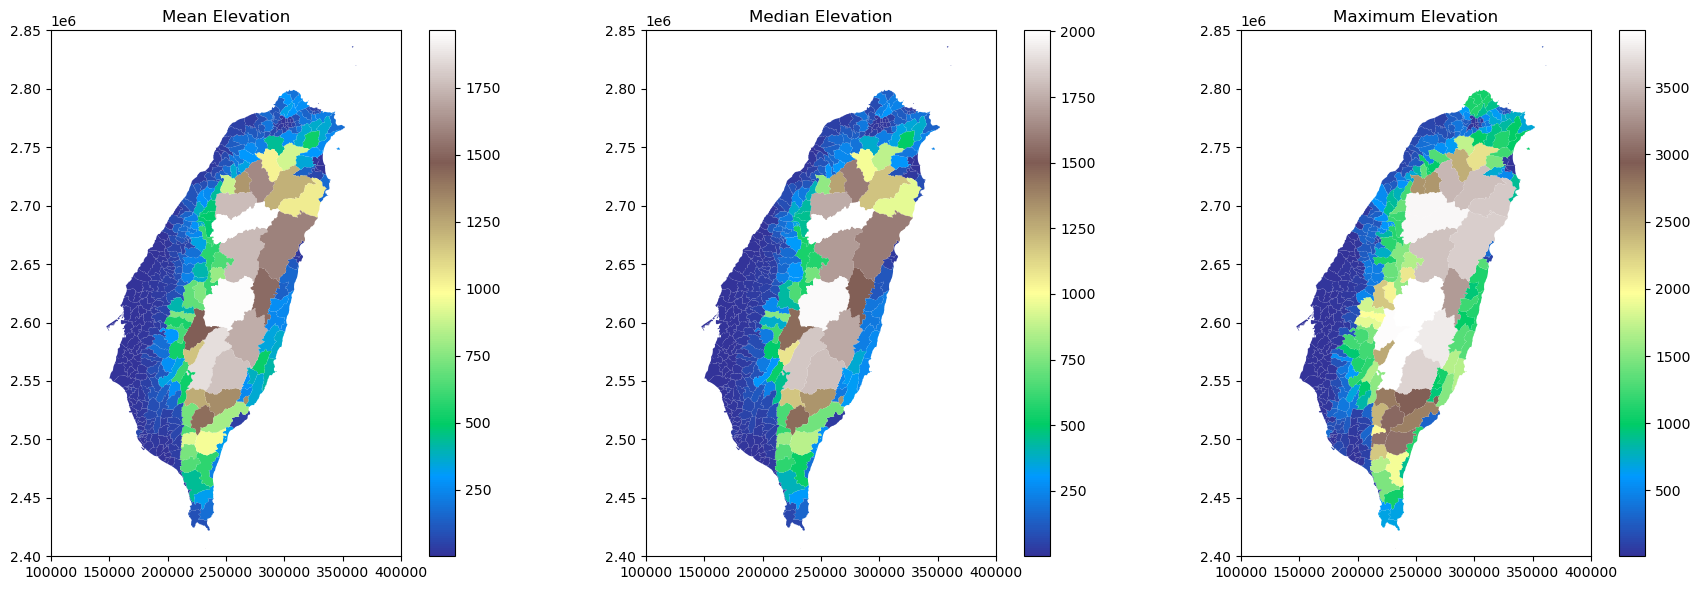

In [33]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

townships.plot(column='mean_elevation', cmap='terrain', legend=True, ax=axs[0])
axs[0].set_title('Mean Elevation')
axs[0].set_xlim(100000, 400000)
axs[0].set_ylim(2400000, 2850000)

townships.plot(column='median_elevation', cmap='terrain', legend=True, ax=axs[1])
axs[1].set_title('Median Elevation')
axs[1].set_xlim(100000, 400000)
axs[1].set_ylim(2400000, 2850000)

townships.plot(column='max_elevation', cmap='terrain', legend=True, ax=axs[2])
axs[2].set_title('Maximum Elevation')
axs[2].set_xlim(100000, 400000)
axs[2].set_ylim(2400000, 2850000)

plt.tight_layout()